In [1]:
import os
print(os.getcwd())

/home/jupyter-bryan/ISA_Data


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.backend import sigmoid
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.regularizers import l1,l2, l1_l2
from tensorflow.keras.layers import Conv1D, Dense, Dropout, LayerNormalization, Bidirectional, LSTM, GRU, Layer, SpatialDropout1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Lambda, Reshape, Flatten, Input, MultiHeadAttention, Flatten, Concatenate, Add, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import random
import torch

2025-12-15 19:33:55.443365: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
def clean_and_interpolate(data):
    df = pd.DataFrame(data).astype(np.float32)
     
    df_linear = df.interpolate(method='linear', limit_direction='both', axis=1, limit=None)
    df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)

    df_final = df_spline.fillna(0)
    
    # Clip extreme values
    df_interpolated_fin = df_final.clip(-1e6, 1e6)
    print(f"Final NaN count: {df_interpolated_fin.isnull().sum().sum()}")
    result = df_interpolated_fin.values
    
    return result

In [5]:
def prepare_multi_region_data(citarum_01_paths, citarum_02_paths, citarum_03_paths, jkt_paths):
    def load_region_data(paths):
        # Load all dataframes for a region
        ndvi_df = pd.read_csv(paths['ndvi'],delimiter=';', encoding='utf-8-sig',decimal=',')
        mndwi_df = pd.read_csv(paths['mndwi'],delimiter=';', encoding='utf-8-sig',decimal=',')
        ndbi_df = pd.read_csv(paths['ndbi'],delimiter=';', encoding='utf-8-sig',decimal=',')
        ndbsi_df = pd.read_csv(paths['ndbsi'],delimiter=';', encoding='utf-8-sig',decimal=',')
        cbi_df = pd.read_csv(paths['cbi'],delimiter=';', encoding='utf-8-sig',decimal=',')
        uci_df = pd.read_csv(paths['uci'],delimiter=';', encoding='utf-8-sig',decimal=',')
        print('NDVI shape before int:', ndvi_df.shape)
        
        # Extract features
        ndvi_features = ndvi_df.iloc[:,5:29].values
        mndwi_features = mndwi_df.iloc[:,5:29].values
        ndbi_features = ndbi_df.iloc[:,5:29].values
        ndbsi_features = ndbsi_df.iloc[:,5:29].values
        cbi_features = cbi_df.iloc[:,5:29].values
        uci_features = uci_df.iloc[:,5:29].values
        print('NDVI shape after int:', ndvi_features.shape)
        
        # Clean and interpolate
        ndvi_features = clean_and_interpolate(ndvi_features)
        mndwi_features = clean_and_interpolate(mndwi_features)
        ndbi_features = clean_and_interpolate(ndbi_features)
        ndbsi_features = clean_and_interpolate(ndbsi_features)
        cbi_features = clean_and_interpolate(cbi_features)
        uci_features = clean_and_interpolate(uci_features)
        
        # Combine features
        X = np.concatenate([ndvi_features, mndwi_features, ndbi_features, 
                            ndbsi_features, cbi_features, uci_features], axis=1)
        
        # Reshape
        X = X.reshape(X.shape[0], 24, 6) 
        
        # Get labels, slope and elev
        labels = ndvi_df.iloc[:, 1].values
        slope_values = ndvi_df.iloc[:,29].values
        elev_values = ndvi_df.iloc[:,30].values
        
        # return X, labels, slope_values
        return X, labels, slope_values, elev_values

    # Load data for both regions
    X_citarum_01, labels_citarum_01, slope_citarum_01, elev_citarum_01 = load_region_data(citarum_01_paths)
    X_citarum_02, labels_citarum_02, slope_citarum_02, elev_citarum_02 = load_region_data(citarum_02_paths)
    X_citarum_03, labels_citarum_03, slope_citarum_03, elev_citarum_03 = load_region_data(citarum_03_paths)
    X_jkt, labels_jkt, slope_jkt, elev_jkt = load_region_data(jkt_paths)
    
    # Combine data from both regions
    X_combined = np.concatenate([X_citarum_01, X_citarum_02, X_citarum_03, X_jkt], axis=0)
    labels_combined = np.concatenate([labels_citarum_01, labels_citarum_02, labels_citarum_03, labels_jkt])
    slope_combined = np.concatenate([slope_citarum_01, slope_citarum_02, slope_citarum_03, slope_jkt])
    elev_combined = np.concatenate([elev_citarum_01, elev_citarum_02, elev_citarum_03, elev_jkt])
    
    # Compute class weights on combined data
    unique_classes = np.unique(labels_combined)

    print("Labels combined shape:", labels_combined.shape)
    print("Labels combined type:", type(labels_combined[0]) if len(labels_combined) > 0 else "Empty")
    print("Unique classes from np.unique:", unique_classes)
    print("Unique classes type:", type(unique_classes[0]) if len(unique_classes) > 0 else "Empty")
    print("All unique values in labels_combined:", set(labels_combined))
    print("Any NaN values?", np.any(pd.isna(labels_combined)))

    # Check if there are any labels in y that aren't in classes
    missing_labels = set(labels_combined) - set(unique_classes)
    print("Labels in y but not in classes:", missing_labels)
    
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=unique_classes,
        y=labels_combined)
    
    class_weight_dict = dict(enumerate(class_weights))
    print("Class weights:", class_weight_dict)
    
    y = np.asarray(labels_combined)
    print(y)
    print(len(np.unique(y)))
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_combined = label_encoder.fit_transform(labels_combined)
    y_combined = to_categorical(y_combined)
    print(y_combined)
    
    # Split combined data
    X_train, X_test, y_train, y_test, slope_train, slope_test, elev_train, elev_test = train_test_split(X_combined, y_combined, 
                                                                                                        slope_combined, elev_combined,
                                                                                                        test_size=0.3,random_state=42,
                                                                                                        stratify=y_combined)
    
    # Convert slope values to tensorflow constant
    slope_train = tf.constant(slope_train, dtype=tf.float32)
    slope_test = tf.constant(slope_test, dtype=tf.float32)

    # Convert elev values to tensorflow constant
    elev_train = tf.constant(elev_train, dtype=tf.float32)
    elev_test = tf.constant(elev_test, dtype=tf.float32)
    
    return (X_train, X_test, y_train, y_test, label_encoder, class_weight_dict, slope_train, slope_test, elev_train, elev_test, y)

In [6]:
citarum_01_paths = {
    'ndvi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_NDVI_ROI_01.csv',
    'mndwi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_MNDWI_ROI_01.csv',
    'ndbi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_NDBI_ROI_01.csv',
    'ndbsi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_NDBSI_ROI_01.csv',
    'cbi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_CBI_ROI_01.csv',
    'uci': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_UCI_ROI_01.csv'
}

citarum_02_paths = {
    'ndvi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_NDVI_ROI_02.csv',
    'mndwi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_MNDWI_ROI_02.csv',
    'ndbi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_NDBI_ROI_02.csv',
    'ndbsi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_NDBSI_ROI_02.csv',
    'cbi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_CBI_ROI_02.csv',
    'uci': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_UCI_ROI_02.csv'
}

citarum_03_paths = {
    'ndvi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_NDVI_ROI_03.csv',
    'mndwi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_MNDWI_ROI_03.csv',
    'ndbi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_NDBI_ROI_03.csv',
    'ndbsi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_NDBSI_ROI_03.csv',
    'cbi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_CBI_ROI_03.csv',
    'uci': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_UCI_ROI_03.csv'
}

jkt_paths = {
    'ndvi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_DKI_NDVI.csv',
    'mndwi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_DKI_MNDWI.csv',
    'ndbi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_DKI_NDBI.csv',
    'ndbsi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_DKI_NDBSI.csv',
    'cbi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_DKI_CBI.csv',
    'uci': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_DKI_UCI.csv'
}

# Prepare the combined data
X_train, X_test, y_train, y_test, label_encoder, class_weight_dict, slope_train, slope_test, elev_train, elev_test, y = prepare_multi_region_data(citarum_01_paths, 
                                                                                                                                                      citarum_02_paths, 
                                                                                                                                                      citarum_03_paths,
                                                                                                                                                      jkt_paths)

NDVI shape before int: (2473, 31)
NDVI shape after int: (2473, 24)
Final NaN count: 0


/tmp/ipykernel_1540998/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_1540998/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)


Final NaN count: 0
Final NaN count: 0


/tmp/ipykernel_1540998/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_1540998/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)


Final NaN count: 0
Final NaN count: 0


/tmp/ipykernel_1540998/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_1540998/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)


Final NaN count: 0
NDVI shape before int: (1972, 31)
NDVI shape after int: (1972, 24)


/tmp/ipykernel_1540998/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_1540998/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_1540998/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)


Final NaN count: 0
Final NaN count: 0
Final NaN count: 0


/tmp/ipykernel_1540998/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_1540998/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_1540998/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)


Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
NDVI shape before int: (533, 31)
NDVI shape after int: (533, 24)
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
NDVI shape before int: (2205, 31)
NDVI shape after int: (2205, 24)


/tmp/ipykernel_1540998/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_1540998/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_1540998/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_1540998/1661099113.py:5: FutureWarning: DataFrame.fillna with

Final NaN count: 0
Final NaN count: 0


/tmp/ipykernel_1540998/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_1540998/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)


Final NaN count: 0
Final NaN count: 0


/tmp/ipykernel_1540998/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_1540998/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)


Final NaN count: 0
Final NaN count: 0
Labels combined shape: (7183,)
Labels combined type: <class 'numpy.int64'>
Unique classes from np.unique: [1 2 3 4 5]
Unique classes type: <class 'numpy.int64'>
All unique values in labels_combined: {np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)}
Any NaN values? False
Labels in y but not in classes: set()
Class weights: {0: np.float64(0.4424391746227287), 1: np.float64(0.8934079601990049), 2: np.float64(0.9115482233502538), 3: np.float64(3.1435448577680525), 4: np.float64(4.8698305084745765)}
[1 1 1 ... 2 2 2]
5
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


I0000 00:00:1765798441.783571 1540998 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6445 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


In [7]:
def conv_bn(X, **conv_params):
    nbunits = conv_params["nbunits"];
    kernel_size = conv_params["kernel_size"];
    
    strides = conv_params.setdefault("strides", 1)
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-6))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    
    Z = Conv1D(nbunits, kernel_size=kernel_size, 
               strides = strides, padding=padding,
               kernel_initializer=kernel_initializer,
               kernel_regularizer=kernel_regularizer)(X)
    
    return BatchNormalization(axis=-1)(Z) #-- CHANNEL_AXIS (-1)

In [8]:
def fc_bn(X, **fc_params):
    nbunits = fc_params["nbunits"];
    kernel_regularizer = fc_params.setdefault("kernel_regularizer", l2(1.e-6))
    kernel_initializer = fc_params.setdefault("kernel_initializer", "he_normal")
    Z = Dense(nbunits, kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer)(X)
    
    return BatchNormalization(axis=-1)(Z) #-- CHANNEL_AXIS (-1)

In [9]:
def conv_bn_relu(X, **conv_params):
    Znorm = conv_bn(X, **conv_params)
    return Activation('relu')(Znorm)

In [10]:
def conv_bn_relu_drop(X, **conv_params):
    dropout_rate = conv_params.setdefault("dropout_rate", 0.5)
    A = conv_bn_relu(X, **conv_params)
    return Dropout(dropout_rate)(A)

In [11]:
def fc_bn_relu(X, **fc_params):
    Znorm = fc_bn(X, **fc_params)
    return Activation('relu')(Znorm)

In [12]:
def fc_bn_relu_drop(X, **fc_params):
    dropout_rate = fc_params.setdefault("dropout_rate", 0.5)
    A = fc_bn_relu(X, **fc_params)
    return Dropout(dropout_rate)(A)

In [13]:
def softmax(X, nbclasses, **params):
    kernel_regularizer = params.setdefault("kernel_regularizer", l2(1.e-6))
    kernel_initializer = params.setdefault("kernel_initializer", "glorot_uniform")
    return Dense(nbclasses, activation='softmax',
                 kernel_initializer=kernel_initializer,
                 kernel_regularizer=kernel_regularizer)(X)

In [14]:
%%time

n_classes=len(label_encoder.classes_)
def make_model(n_classes, n_timesteps=24, n_features=6):
    l2_rate = 0.000001
    dropout_rate = 0.5
    nb_rnn = 3
    nbunits_rnn = 128
    nbunits_fc = 256
    
    input_layer = Input(shape=(n_timesteps, n_features))
    X = input_layer
    for add in range(nb_rnn-1):
        X = Bidirectional(GRU(nbunits_rnn, return_sequences=True))(X)
        X = Dropout(dropout_rate)(X)
        X = Bidirectional(GRU(nbunits_rnn, return_sequences=False))(X)
        X = Dropout(dropout_rate)(X)
        #-- 1 FC layers
        
        X = fc_bn_relu_drop(X, nbunits=nbunits_fc, kernel_regularizer=l2(l2_rate), dropout_rate=dropout_rate)
        #-- SOFTMAX layer
        out = softmax(X, n_classes, kernel_regularizer=l2(l2_rate)) 
        # Create model
        
        return Model(inputs=input_layer, outputs=out)

model = make_model(n_classes=len(label_encoder.classes_))
model.summary()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=Adam(learning_rate=0.001), 
              metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath='/home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_TempCNN.keras',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='max')

early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=100,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.1,
                              patience=30, 
                              min_lr=0.00001)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    batch_size =20,
                    epochs=500, 
                    callbacks = [checkpoint, early_stop, reduce_lr], 
                    class_weight = class_weight_dict)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 24, 256)        │       104,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       296,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 468,997 (1.79 MB)

 Trainable params: 468,485 (1.79 MB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/500


2025-12-15 19:34:05.984642: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


250/252 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6133 - loss: 1.1063
Epoch 1: val_accuracy improved from None to 0.87657, saving model to /home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_TempCNN.keras
252/252 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7013 - loss: 0.8558 - val_accuracy: 0.8766 - val_loss: 0.3871 - learning_rate: 0.0010
Epoch 2/500
249/252 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7816 - loss: 0.5793
Epoch 2: val_accuracy did not improve from 0.87657
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7932 - loss: 0.5562 - val_accuracy: 0.8747 - val_loss: 0.3700 - learning_rate: 0.0010
Epoch 3/500
247/252 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8259 - loss: 0.4881
Epoch 3: val_accuracy did not improve from 0.87657
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8248 - loss: 0.4832 - val_accuracy: 0.8274 - val_loss: 0.4155 - learning_rate: 0.0010
Epoch 4/500
251/252 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8151 - loss: 0.4945

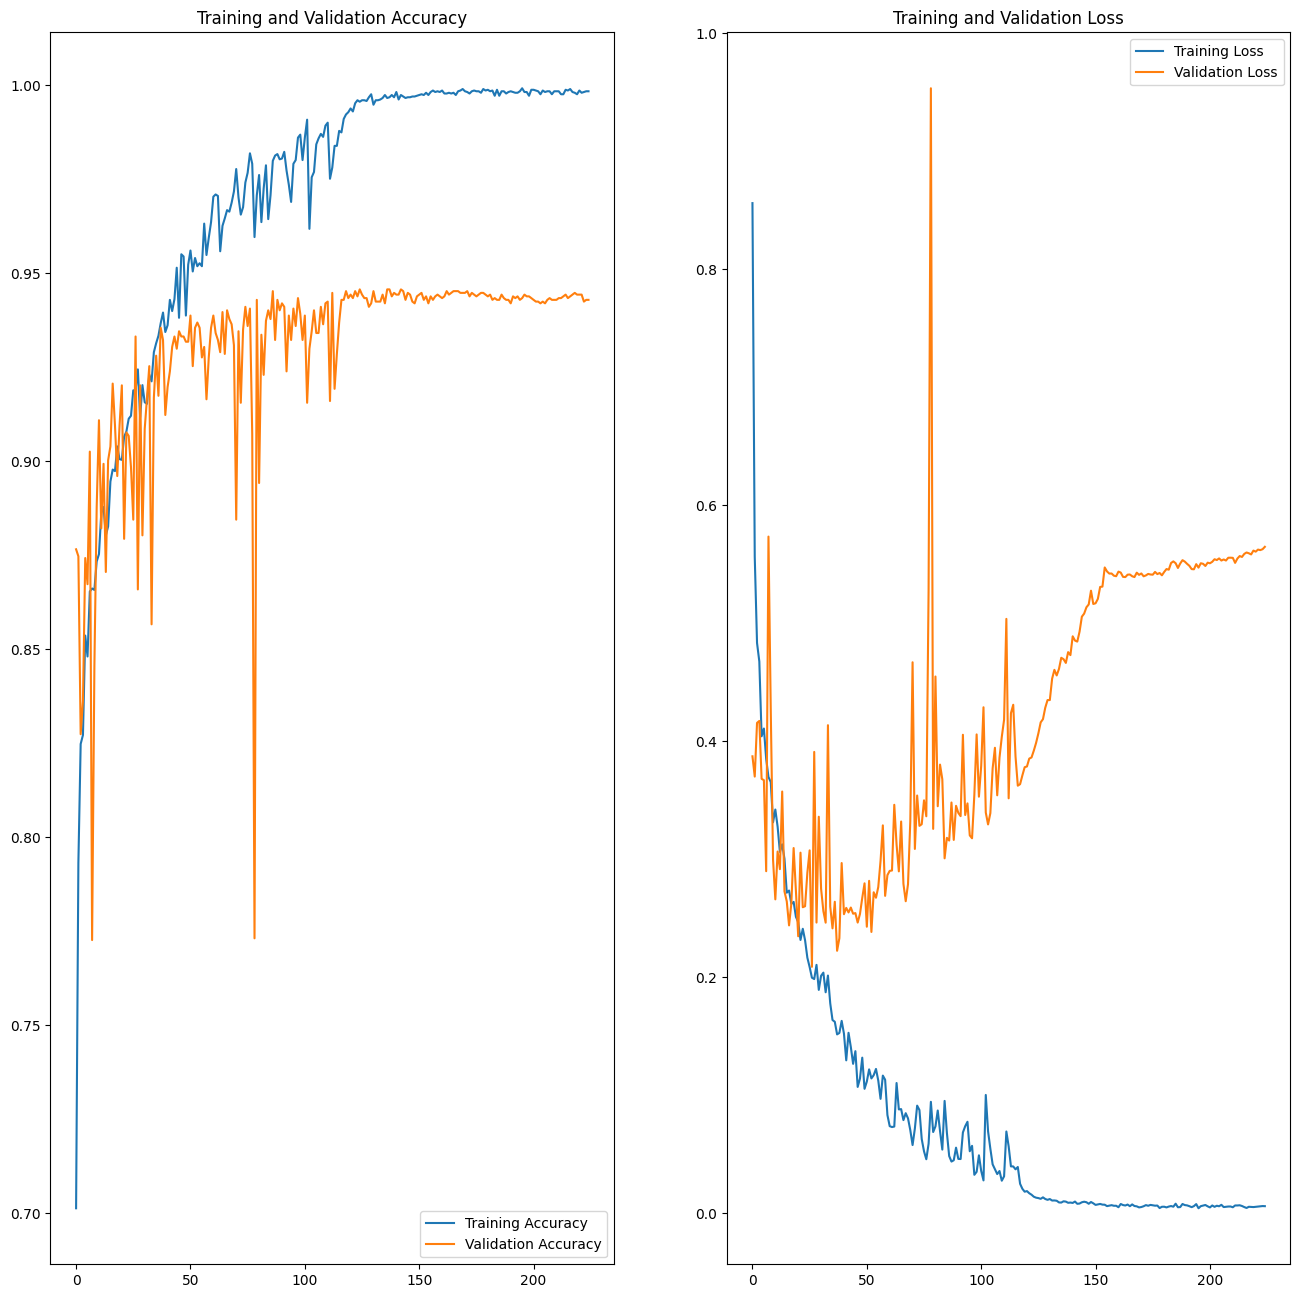

In [15]:
n_epochs = len(history.history['loss'])

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(n_epochs) #change it based on epoch needed to finish building the model

plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


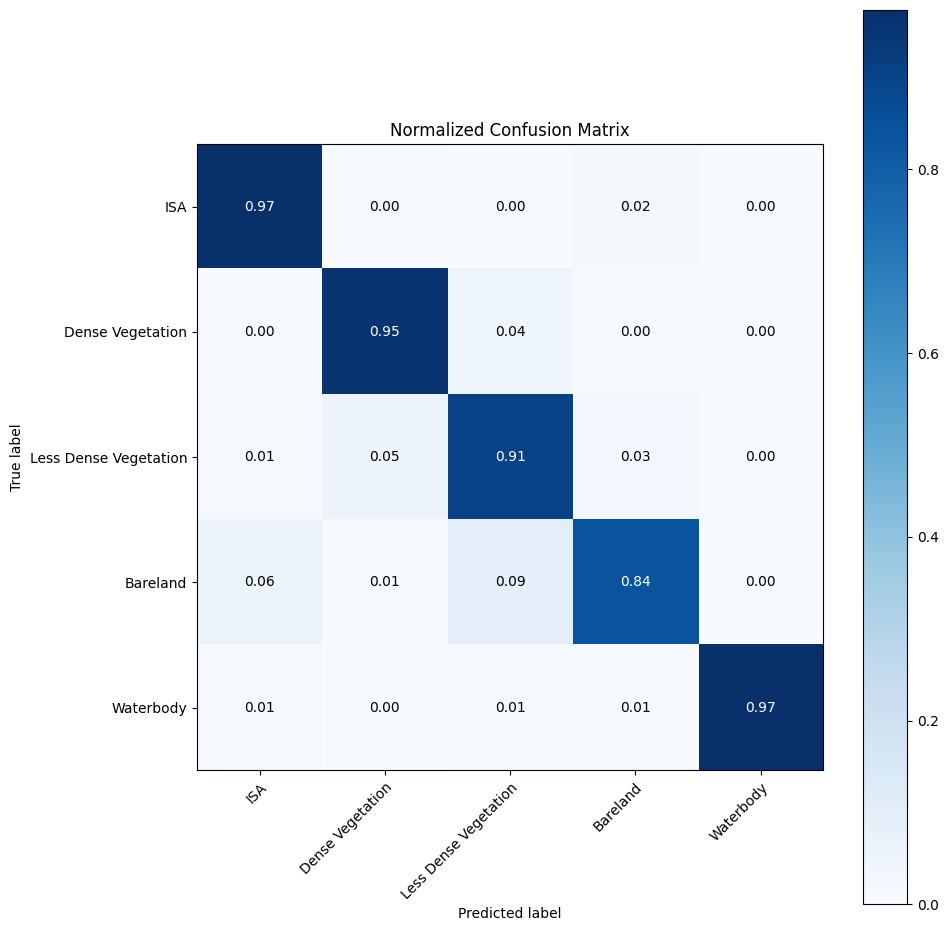

In [16]:
#confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

classes = ['ISA','Dense Vegetation','Less Dense Vegetation', 'Bareland', 'Waterbody']

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
score = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

dl_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(dl_cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(dl_cm.shape[1]),
        yticks=np.arange(dl_cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes, yticklabels=classes,
        title='Normalized Confusion Matrix',
        ylabel='True label',
        xlabel='Predicted label')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
          rotation_mode="anchor")

fmt = '.2f'
thresh = dl_cm.max() / 2.
for i in range(dl_cm.shape[0]):
    for j in range(dl_cm.shape[1]):
        ax.text(j, i, format(dl_cm[i, j], fmt),
                ha="center", va="center",
                color="white" if dl_cm[i, j] > thresh else "black")
fig.tight_layout()